# Deriving energy values

In this tutorial, we show how derived fields and values can be computed afetr the micromagnetic system is defined.

## Simulation

First of all, as usual, we import `oommfc` and `discretisedfield`.

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm

We define the cube mesh with edge length $10 \,\text{nm}$ and cell discretisation edge $1 \,\text{nm}$.

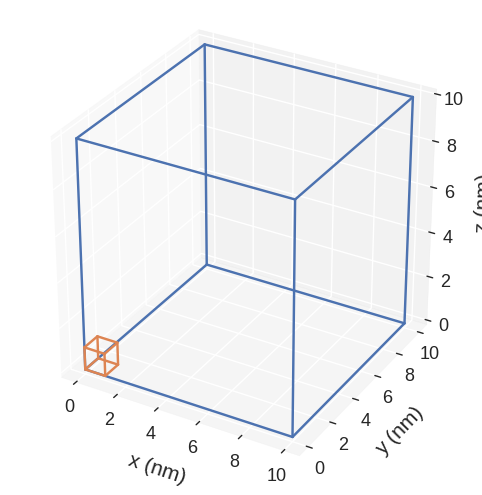

In [2]:
mesh = df.Mesh(p1=(0, 0, 0), p2=(10e-9, 10e-9, 10e-9), cell=(1e-9, 1e-9, 1e-9))
mesh.mpl()

Now we define the system object and its Hamiltonian.

In [3]:
system = mm.System(name='system')

A = 1e-11
H = (0.1/mm.consts.mu0, 0, 0)
K = 1e3
u = (1, 1, 1)
system.energy = (mm.Exchange(A=A)
                 + mm.Demag()
                 + mm.Zeeman(H=H)
                 + mm.UniaxialAnisotropy(K=K, u=u))

system.energy

Exchange(A=1e-11) + Demag() + Zeeman(H=(79577.47154594767, 0, 0)) + UniaxialAnisotropy(K=1000.0, u=(1, 1, 1))

We will now intialise the system in $(0, 0, 1)$ direction with $M_\text{s} = 8\times 10^{5} \,\text{A/m}$ and relax the magnetisation.

In [4]:
Ms = 8e5
system.m = df.Field(mesh, nvdim=3, value=(0, 0, 1), norm=Ms)

## Effective field

All computations are performed using `mc.compute`, where `mc` is the micromagnetic calculator we choose at import. `compute` function takes two arguments:

1. Property we want to compute
2. System object

Total effective field is:

Running OOMMF (ExeOOMMFRunner)[2023/08/09 14:22]... (0.4 s)


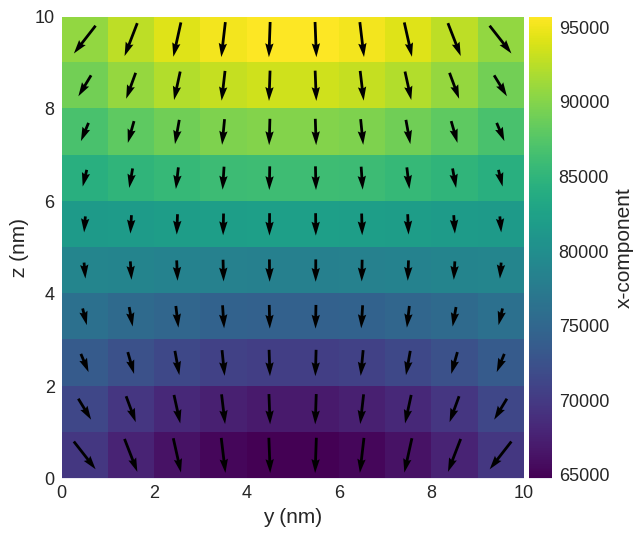

In [5]:
oc.compute(system.energy.effective_field, system).sel('x').mpl()

Similarly, the individual exchange effective field is:

In [6]:
Hex_eff = oc.compute(system.energy.exchange.effective_field, system)

Running OOMMF (ExeOOMMFRunner)[2023/08/09 14:22]... (0.2 s)


Because we initialised the system with the uniform state, we expect this effective field to be zero.

In [7]:
Hex_eff.mean()

array([0., 0., 0.])

The energy density is:

Running OOMMF (ExeOOMMFRunner)[2023/08/09 14:22]... (0.2 s)


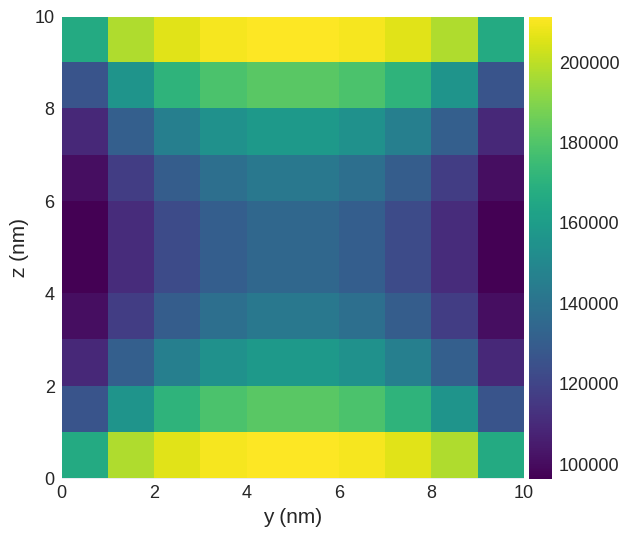

In [8]:
w = oc.compute(system.energy.density, system)
w.sel('x').mpl()

Similarly, the energy (volume integral of energy density) is:

In [9]:
E = oc.compute(system.energy.energy, system)
print(f'The energy of the system is {E} J.')

Running OOMMF (ExeOOMMFRunner)[2023/08/09 14:22]... (0.3 s)
The energy of the system is 1.3470795322e-19 J.


## Relax the system

In [10]:
md = oc.MinDriver()
md.drive(system)

Running OOMMF (ExeOOMMFRunner)[2023/08/09 14:22]... (0.4 s)


Compute the energy (and demonstrate that the energy decreased) and plot its magnetisation:

Running OOMMF (ExeOOMMFRunner)[2023/08/09 14:22]... (0.2 s)
The system's energy is 5.35285533145e-20 J.


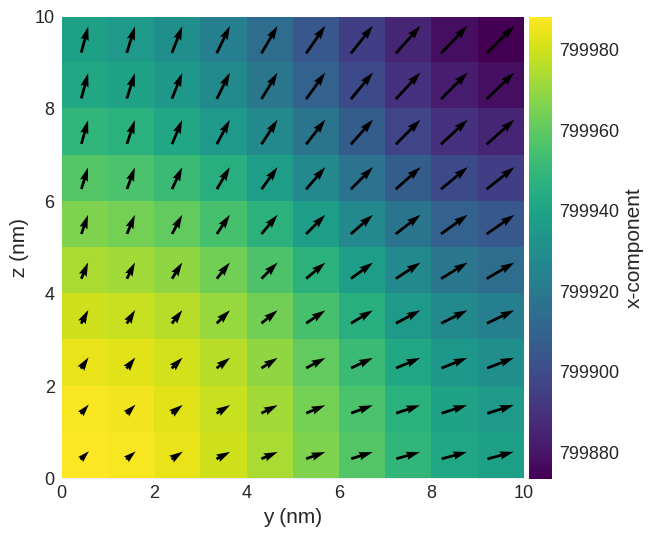

In [11]:
E = oc.compute(system.energy.energy, system)
print("The system's energy is {} J.".format(E))

system.m.sel('x').mpl()

## Computing energies of individual term

For instance, the exchange energy is:

In [12]:
oc.compute(system.energy.exchange.energy, system)

Running OOMMF (ExeOOMMFRunner)[2023/08/09 14:22]... (0.3 s)


1.12170202161e-21

We can also chack the sum of all individual energy terms and check if it the same as the total energy.

In [13]:
total_energy = 0
for term in system.energy:
    total_energy += oc.compute(term.energy, system)
    
print("The sum of energy terms is {} J.".format(total_energy))
print("The system's energy is {} J.".format(oc.compute(system.energy.energy, system)))

Running OOMMF (ExeOOMMFRunner)[2023/08/09 14:22]... (0.2 s)
Running OOMMF (ExeOOMMFRunner)[2023/08/09 14:22]... (0.2 s)
Running OOMMF (ExeOOMMFRunner)[2023/08/09 14:22]... (0.2 s)
Running OOMMF (ExeOOMMFRunner)[2023/08/09 14:22]... (0.2 s)
The sum of energy terms is 5.3528553314592996e-20 J.
Running OOMMF (ExeOOMMFRunner)[2023/08/09 14:22]... (0.2 s)
The system's energy is 5.35285533145e-20 J.
